# import module

In [1]:
import os
gpu_number = "0"
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_number
from glob import glob

import tensorflow as tf
import numpy as np
from tensorflow.keras import backend as keras_backend
import segmentation_models as sm

from PIL import Image

from src.data_loader.segmentation import SegDataloader

sm.set_framework ('tf.keras')

Segmentation Models: using `keras` framework.


In [2]:
gpu_on = True

if gpu_on :
    gpu_devices = tf.config.experimental.list_physical_devices("GPU")
    for device in gpu_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    gpu_devices = tf.config.experimental.list_physical_devices("CPU")

print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
from src.data_loader.segmentation import SegDataloader
from glob import glob

BACKBONE="inceptionv3"

task = "segmentation"
data_set_name = "ihc_auto_curation_level_1"
batch_size = 4
on_memory = True
augmentation_proba = 0.8
preprocess_input = sm.get_preprocessing(BACKBONE)
target_size = None
interpolation = "bilinear"
dtype = "float32"

mask_iter = 6

total_image_path_list = glob(f"./datasets/{task}/{data_set_name}/fold_[0-7]/ihc_revised/*.png")
total_mask_path_list = glob(f"./datasets/{task}/{data_set_name}/fold_[0-7]/mask_iter_{mask_iter}/*.png")

valid_image_path_list = glob(f"./datasets/{task}/{data_set_name}/fold_0/ihc_revised/*.png")
valid_mask_path_list = glob(f"./datasets/{task}/{data_set_name}/fold_0/mask_iter_{mask_iter}/*.png")

test_image_path_list = glob(f"./datasets/{task}/{data_set_name}/fold_[6-7]/ihc_revised/*.png")
test_mask_path_list = glob(f"./datasets/{task}/{data_set_name}/fold_[6-7]/mask_iter_{mask_iter}/*.png")

train_image_path_list = set(total_image_path_list) - set(valid_image_path_list) - set(test_image_path_list)
train_image_path_list = list(train_image_path_list)
train_image_path_list.sort()
train_mask_path_list = set(total_mask_path_list) - set(valid_mask_path_list) - set(test_mask_path_list)
train_mask_path_list = list(train_mask_path_list)
train_mask_path_list.sort()

train_data_loader = SegDataloader(image_path_list=train_image_path_list,
                                  mask_path_list=train_mask_path_list,
                                  batch_size=batch_size,
                                  on_memory=on_memory,
                                  augmentation_proba=augmentation_proba,
                                  preprocess_input=preprocess_input,
                                  target_size=target_size,
                                  interpolation=interpolation,
                                  shuffle=True,
                                  dtype=dtype
                                  )
valid_data_loader = SegDataloader(image_path_list=valid_image_path_list,
                                  mask_path_list=valid_mask_path_list,
                                  batch_size=batch_size,
                                  on_memory=on_memory,
                                  augmentation_proba=0,
                                  preprocess_input=preprocess_input,
                                  target_size=target_size,
                                  interpolation=interpolation,
                                  shuffle=True,
                                  dtype=dtype
                                  )
test_data_loader = SegDataloader(image_path_list=test_image_path_list,
                                  mask_path_list=test_mask_path_list,
                                  batch_size=1,
                                  on_memory=False,
                                  augmentation_proba=0,
                                  preprocess_input=preprocess_input,
                                  target_size=target_size,
                                  interpolation=interpolation,
                                  shuffle=False,
                                  dtype=dtype
                                  )

 [3105/3105] |##############################################| (Time:  0:03:50) 
 [01/621] |                                                 | (ETA:   0:01:13) 

Total data num 3105


 [621/621] |################################################| (Time:  0:00:41) 


Total data num 621
Total data num 1247


In [4]:
# create the base pre-trained model~
model = sm.Unet(backbone_name=BACKBONE, input_shape=(
            None, None, 3), classes=1, activation='sigmoid')

87916544/87910968 [==============================] - 4s 0us/step


In [5]:
from datetime import date

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.optimizers import Nadam

from src.util.custom_loss import PropotionalDiceLoss, TverskyLoss, dice_score, dice_loss, boundary_loss
from segmentation_models.losses import DiceLoss, BinaryFocalLoss

today = date.today()

# YY/MM/dd
today_str = today.strftime("%Y-%m-%d")
today_weight_path = f"./result_daily/{task}/{data_set_name}/{today_str}/gpu_{gpu_number}/target_size_{target_size}/iter_{mask_iter}/weights/" 
today_logs_path = f"./result_daily/{task}/{data_set_name}/{today_str}/gpu_{gpu_number}/target_size_{target_size}/iter_{mask_iter}/"
os.makedirs(today_weight_path, exist_ok=True)
os.makedirs(today_logs_path, exist_ok=True)
optimizer = Nadam(1e-4, clipnorm=1)

save_c = ModelCheckpoint(
    today_weight_path+"/weights_{val_loss:.4f}_{loss:.4f}_{epoch:02d}.hdf5",
    monitor='val_loss',
    verbose=0,
    save_best_only=False,
    save_weights_only=True,
    mode='min')


reduceLROnPlat = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=20,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=5,
    min_lr=1e-7)
csv_logger = CSVLogger(f'{today_logs_path}/log.csv', append=False, separator=',')

model.compile(optimizer=optimizer, loss=PropotionalDiceLoss(include_focal=True, include_boundary=False), metrics=[dice_score])

In [ ]:
start_epoch = 0

if mask_iter <= 1:
    epochs = 50
else:
    epochs = 20
model.fit(
    train_data_loader,
    validation_data=valid_data_loader,
    epochs=epochs,
    callbacks=[reduceLROnPlat, save_c, csv_logger],
    initial_epoch=start_epoch
)

Epoch 1/20
776/776 [==============================] - 502s 586ms/step - loss: 0.1089 - dice_score: 0.7113 - val_loss: 0.0521 - val_dice_score: 0.8607
Epoch 2/20
776/776 [==============================] - 456s 588ms/step - loss: 0.0322 - dice_score: 0.8707 - val_loss: 0.0498 - val_dice_score: 0.7127
Epoch 3/20
776/776 [==============================] - 456s 588ms/step - loss: 0.0165 - dice_score: 0.8954 - val_loss: 0.0118 - val_dice_score: 0.9352
Epoch 4/20
776/776 [==============================] - 457s 589ms/step - loss: 0.0112 - dice_score: 0.9108 - val_loss: 0.0077 - val_dice_score: 0.9465
Epoch 5/20
776/776 [==============================] - 458s 590ms/step - loss: 0.0089 - dice_score: 0.9180 - val_loss: 0.0109 - val_dice_score: 0.9012
Epoch 6/20
776/776 [==============================] - 459s 591ms/step - loss: 0.0079 - dice_score: 0.9229 - val_loss: 0.0077 - val_dice_score: 0.9276
Epoch 7/20
776/776 [==============================] - 455s 587ms/step - loss: 0.0068 - dice_score: 0

# Inference

['epoch', 'dice_score', 'loss', 'lr', 'val_dice_score', 'val_loss']
val_loss_min (epoch, loss, accuracy): (11, 0.0052, 0.9352)
val_dice_score_max (epoch, loss, accuracy): (3, 0.0088, 0.9371)
loss_score_diff_min (epoch, loss, accuracy): (3, 0.0088, 0.9371)


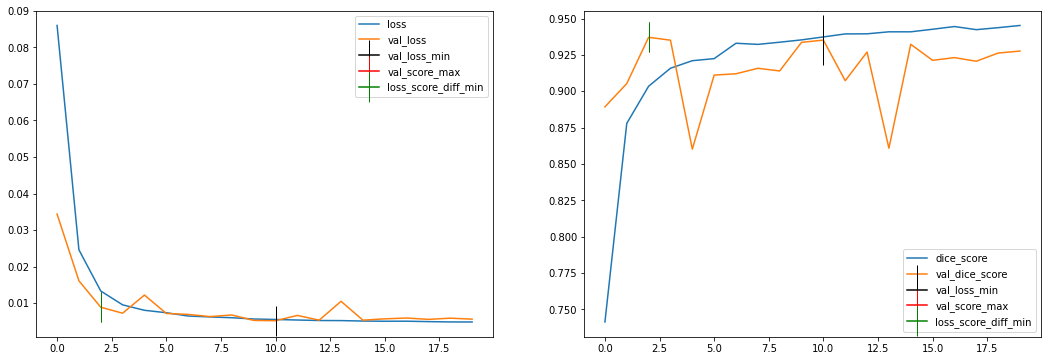

In [25]:
import csv
import shutil
import numpy as np
from glob import glob
from matplotlib import pyplot as plt

result_path = f"./result_daily/{task}/{data_set_name}/{today_str}/gpu_{gpu_number}/target_size_None/iter_{mask_iter}/"
result_weights = glob(f'{result_path}/weights/*')

with open(f'{result_path}/log.csv') as csv_file:
    reader = csv.DictReader(csv_file)
    dict_from_csv = {field_name:[] for field_name in reader.fieldnames}
    print(reader.fieldnames)
    for row in reader:
        for filedname in reader.fieldnames:
            dict_from_csv[filedname].append(float(row[filedname])) 

loss_min_epoch = np.argmin(dict_from_csv['val_loss']) + 1
loss_min_loss = np.min(dict_from_csv['val_loss'])
loss_min_accuracy = dict_from_csv['val_dice_score'][loss_min_epoch - 1]

score_max_epoch = np.argmax(dict_from_csv['val_dice_score']) + 1
score_max_loss = dict_from_csv['val_loss'][score_max_epoch - 1]
score_max_accuracy = np.max(dict_from_csv['val_dice_score'])

val_score = dict_from_csv['val_dice_score']
score_diff = np.maximum(np.array(dict_from_csv['dice_score'] - np.array(dict_from_csv['val_dice_score'])), 0)

loss_score_diff_min_epoch = np.argmax(val_score - score_diff) + 1
loss_score_diff_min_loss = dict_from_csv['val_loss'][loss_score_diff_min_epoch - 1]
loss_score_diff_min_accuracy = dict_from_csv['val_dice_score'][loss_score_diff_min_epoch - 1]

print(f"val_loss_min (epoch, loss, accuracy): ({loss_min_epoch}, {loss_min_loss:.4f}, {loss_min_accuracy:.4f})")
print(f"val_dice_score_max (epoch, loss, accuracy): ({score_max_epoch}, {score_max_loss:.4f}, {score_max_accuracy:.4f})")
print(f"loss_score_diff_min (epoch, loss, accuracy): ({loss_score_diff_min_epoch}, {loss_score_diff_min_loss:.4f}, {loss_score_diff_min_accuracy:.4f})")

_, ax = plt.subplots(1, 2, figsize=(18, 6))

ax[0].plot(dict_from_csv["loss"])
ax[0].plot(dict_from_csv["val_loss"])
ax[0].plot(loss_min_epoch - 1, loss_min_loss, marker="|", color="black", markersize=30)
ax[0].plot(score_max_epoch - 1, dict_from_csv['val_loss'][score_max_epoch - 1], marker="|", color="red", markersize=30)
ax[0].plot(loss_score_diff_min_epoch - 1, dict_from_csv['val_loss'][loss_score_diff_min_epoch - 1], marker="|", color="green", markersize=30)
ax[0].legend(["loss", "val_loss", "val_loss_min", "val_score_max", "loss_score_diff_min"])

ax[1].plot(dict_from_csv["dice_score"])
ax[1].plot(dict_from_csv["val_dice_score"])
ax[1].plot(loss_min_epoch - 1, dict_from_csv['val_dice_score'][loss_min_epoch - 1], marker="|", color="black", markersize=50)
ax[1].plot(score_max_epoch - 1, score_max_accuracy, marker="|", color="red", markersize=30)
ax[1].plot(loss_score_diff_min_epoch - 1, dict_from_csv['val_dice_score'][loss_score_diff_min_epoch - 1], marker="|", color="green", markersize=30)
ax[1].legend(["dice_score", "val_dice_score", "val_loss_min", "val_score_max", "loss_score_diff_min"])

plt.savefig(f"{result_path}/learning curve.png", dpi=300)
plt.show()
plt.close()


In [26]:
best_loss_path = glob(f"{result_path}/weights/weights_{loss_min_loss:.4f}_*.hdf5")[0]
shutil.copy(best_loss_path, f"{result_path}/epoch_{loss_min_epoch}_loss_{loss_min_loss:.4f}_dice_{loss_min_accuracy:.4f}.hdf5")
print(best_loss_path)

model.load_weights(best_loss_path)
model.evaluate(test_data_loader)

./result_daily/segmentation/ihc_auto_curation_level_1/2021-08-02/gpu_0/target_size_None/iter_5//weights/weights_0.0052_0.0056_10.hdf5
1247/1247 [==============================] - 118s 95ms/step - loss: 0.0052 - dice_score: 0.9361


[0.005183078348636627, 0.9361258149147034]

In [31]:
best_score_path = glob(f"{result_path}/weights/*_{score_max_epoch:02d}.hdf5")[0]
shutil.copy(best_score_path, f"{result_path}/epoch_{score_max_epoch}_loss_{score_max_loss:.4f}_dice_{score_max_accuracy:.4f}.hdf5")
print(best_score_path)

model.load_weights(best_score_path)
model.evaluate(test_data_loader)

./result_daily/segmentation/ihc_auto_curation_level_1/2021-08-02/gpu_0/target_size_None/iter_5//weights/weights_0.0088_0.0133_03.hdf5
1247/1247 [==============================] - 101s 81ms/step - loss: 0.0086 - dice_score: 0.9402


[0.008609097450971603, 0.9401721358299255]

In [32]:
best_diff_path = glob(f"{result_path}/weights/*_{loss_score_diff_min_epoch:02d}.hdf5")[0]
shutil.copy(best_diff_path, f"{result_path}/epoch_{loss_score_diff_min_epoch}_loss_{loss_score_diff_min_loss:.4f}_dice_{loss_score_diff_min_accuracy:.4f}.hdf5")
print(best_diff_path)

model.load_weights(best_diff_path)
model.evaluate(test_data_loader)

./result_daily/segmentation/ihc_auto_curation_level_1/2021-08-02/gpu_0/target_size_None/iter_5//weights/weights_0.0088_0.0133_03.hdf5
1247/1247 [==============================] - 102s 82ms/step - loss: 0.0086 - dice_score: 0.9402


[0.008609097450971603, 0.9401721358299255]

# Make Revised Patch

In [33]:
def dice_coef(y_true, y_pred):
    smooth = 0.0001
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth) # 1>= loss >0

In [37]:
model.load_weights(best_diff_path)

In [38]:
from tqdm import tqdm

from src.data_loader.utils import get_parent_dir_name
from src.data_loader.utils import imread

threshold = 0.1

image_preprocess_method = test_data_loader.data_getter.image_preprocess_method
mask_preprocess_method = test_data_loader.data_getter.mask_preprocess_method
mask_postprocess_method = lambda mask_array: ((mask_array >= threshold) * 255).astype("uint8")
dice_score_list = []

for image_path in tqdm(test_image_path_list):
    image_basename = os.path.basename(image_path)
    image_parent_folder = get_parent_dir_name(image_path, level=1)
    image_dir = os.path.dirname(image_path)
    current_mask_parent_folder = f"mask_iter_{mask_iter}"
    new_mask_parent_folder = f"mask_iter_{mask_iter + 1}"
    new_mask_dir = image_dir.replace(image_parent_folder, new_mask_parent_folder)
    current_mask_path = image_path.replace(image_parent_folder, current_mask_parent_folder)
    new_mask_path = image_path.replace(image_parent_folder, new_mask_parent_folder)
    
    os.makedirs(new_mask_dir, exist_ok=True)
    
    image_array = imread(image_path, channel="rgb")
    image_array = np.expand_dims(image_array, axis=0)
    image_array = image_preprocess_method(image_array)
    
    current_mask_array = imread(current_mask_path)
    new_mask_array = model.predict(image_array)
    
    dice_score = dice_coef((current_mask_array >= threshold) * 1, (new_mask_array >= threshold)*1)
    new_mask_array = mask_postprocess_method(new_mask_array)[0,:,:,0]

    Image.fromarray(new_mask_array).save(new_mask_path)
    dice_score_list.append(dice_score)
    
print(np.mean(dice_score_list))
print(np.std(dice_score_list))

100%|██████████| 1247/1247 [03:49<00:00,  5.44it/s]

0.9313409088497783
0.12219587094589816


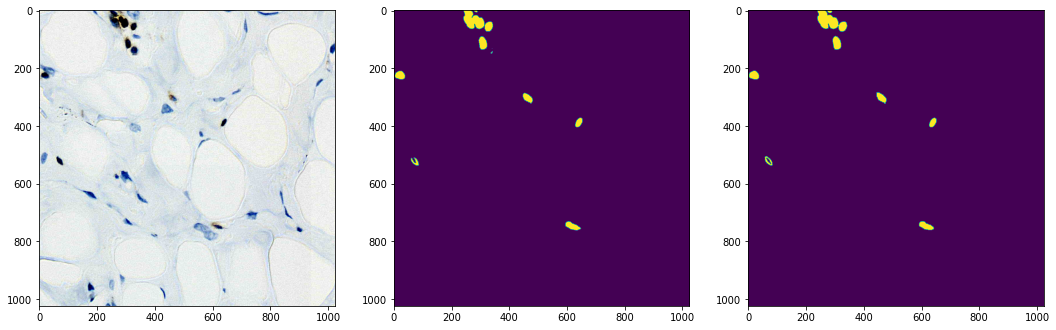

In [39]:
_, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(image_array[0])
ax[1].imshow(current_mask_array)
ax[2].imshow(new_mask_array)

# Check Revised Patch

In [14]:
from PIL import Image

threshold = 0.2
path_common = f"./patch_confirm"
os.makedirs(path_common, exist_ok=True)

dice_score_list = []
for index, (image_array, mask_array) in enumerate(test_data_loader):
    predicted_mask_tensor = model.predict(image_array)
    
    image_array = ((image_array + 1) * 127.5)[0]
    image_array = image_array.astype("uint8")
    
    mask_array_binary = (mask_array >= threshold) * 255
    mask_array_binary = mask_array_binary.astype("uint8")[0,:,:,0]
    
    predicted_mask_array = predicted_mask_tensor[0,:,:,0]
    
    predicted_mask_array_continuous = np.round(predicted_mask_array * 255)
    predicted_mask_array_continuous = predicted_mask_array_continuous.astype("uint8")
    
    predicted_mask_array_binary = (predicted_mask_array >= threshold) * 255
    predicted_mask_array_binary = predicted_mask_array_binary.astype("uint8")
    
    dice_score = dice_coef((mask_array >= threshold) * 1, (predicted_mask_array >= threshold)*1)
    
    image_PIL = Image.fromarray(image_array).convert("RGBA")
    mask_PIL = Image.fromarray(mask_array_binary).convert("RGBA")
    mask_predicted_continuous_PIL = Image.fromarray(predicted_mask_array_continuous).convert("RGBA")
    mask_predicted_binary_PIL = Image.fromarray(predicted_mask_array_binary).convert("RGBA")
    
    image_overlay_origin_PIL = Image.blend(image_PIL, mask_PIL, 0.5)
    image_overlay_predicted_PIL = Image.blend(image_PIL, mask_predicted_binary_PIL, 0.5)
    
    image_PIL.save(f"{path_common}/{dice_score:.4f}_{index}_ihc_image.png")
    mask_PIL.save(f"{path_common}/{dice_score:.4f}_{index}_qupath_mask.png")
    mask_predicted_continuous_PIL.save(f"{path_common}/{dice_score:.4f}_{index}_pred_continuous.png")
    mask_predicted_binary_PIL.save(f"{path_common}/{dice_score:.4f}_{index}_pred_binary.png")
    image_overlay_origin_PIL.save(f"{path_common}/{dice_score:.4f}_{index}_overlay_qupath.png")
    image_overlay_predicted_PIL.save(f"{path_common}/{dice_score:.4f}_{index}_overlay_pred.png")
    
    dice_score_list.append(dice_score)
    print(index)
    
print(np.mean(dice_score_list))
print(np.std(dice_score_list))

0
1
2
3


Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7f8455a1e840>
Traceback (most recent call last):
  File "/usr/lib/python3.6/weakref.py", line 356, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
from matplotlib import pyplot as plt

image, mask = train_data_loader[0]

image = (image + 1) * 127.5
mask = (mask * 255)

image = image.astype("uint8")[0]
mask = mask.astype("uint8")[0]

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(18, 6))
ax[0].imshow(image)
ax[1].imshow(mask)
plt.show()
plt.close()